In [ ]:
import pandas as pd
from glob2 import glob
import numpy as np
import datetime

path = pd.DataFrame(glob('C:\\Users\\admin\\Desktop\\sdk\\powertechfund\\data\\*'),columns=['location'])
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# final_intraday_log = pd.DataFrame(columns=['Entry_Datetime','Spot_Traded_Price','ATM','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])
# intraday_trade_logs = {}
final_intraday_log = pd.DataFrame(columns=['Entry_Datetime','Spot_Traded_Price','ATM','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])


for index,row in path.iterrows():
    df_data = pd.read_csv(row['location'], low_memory=False)


# file_path = 'data\\spx_01x_202206_dayExpiry.txt'
# df_data = pd.read_csv(file_path)
    df_data.columns = ['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
           'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
           'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME',
           'C_LAST', 'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK',
           'P_SIZE', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA',
           'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE',
           'STRIKE_DISTANCE_PCT']
        
    # # Create a boolean mask to filter rows that do not match the specified dates
    # mask = ~df_data['QUOTE_DATE'].isin(['2022-06-17', '2022-06-24'])
    
    # # Use the boolean mask to filter the DataFrame and drop the specified rows
    # df_data = df_data[mask]
    
    df_data['STRIKE'] = df_data['STRIKE'].apply(lambda x : int(x))
    # df_data['C_BID'] = df_data['C_BID'].apply(lambda x: float(x))
    # df_data['C_ASK'] = df_data['C_ASK'].apply(lambda x: float(x))
    # df_data['P_BID'] = df_data['P_BID'].apply(lambda x: float(x))
    # df_data['P_ASK'] = df_data['P_ASK'].apply(lambda x: float(x))
    # df_data['C_LTP'] = (df_data['C_BID']+ df_data['C_ASK']) /2
    # df_data['P_LTP'] = (df_data['P_BID']+ df_data['P_ASK']) /2
    df_data['QUOTE_DATE'] = df_data['QUOTE_DATE'].apply(lambda x : pd.to_datetime(x) )
    #intraday_trade_logs[f"intraday_trade_log_{index}"] = pd.DataFrame(columns=['Entry_Datetime','Spot_Traded_Price','ATM','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])
    intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Spot_Traded_Price','ATM','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])

    #intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Spot_Traded_Price','ATM','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])
    date_list = df_data['QUOTE_DATE'].unique()
    for dts in date_list:
        try:
            #print(dts)
            intraday_data = df_data[(df_data['QUOTE_DATE']==dts) ]#& (intraday_data['STRIKE'] == atm)    
            #print(intraday_data)
            
            # entry_time = datetime.datetime.combine(intraday_data['QUOTE_DATE'][0].date(), datetime.time(9, 45))
            # exit_time = datetime.datetime.combine(intraday_data['QUOTE_DATE'][0].date(), datetime.time(15, 30))
            entry_time = datetime.datetime.combine(intraday_data['QUOTE_DATE'].iloc[0].date(), datetime.time(9, 45))
            exit_time = datetime.datetime.combine(intraday_data['QUOTE_DATE'].iloc[0].date(), datetime.time(15, 30))
            
                    
            # Format datetime objects with a leading space
            formatted_entry_time = entry_time.strftime(' %Y-%m-%d %H:%M')
            formatted_exit_time = exit_time.strftime(' %Y-%m-%d %H:%M')
            
            atm = intraday_data[intraday_data['QUOTE_READTIME'] == formatted_entry_time]['UNDERLYING_LAST'].iloc[0]
            base = 10
            atm = base*round(atm/base)
            
            final_intraday_data = intraday_data[(intraday_data['STRIKE'] == atm)]#(intraday_data['QUOTE_DATE']==" 2022-06-02") &
            final_intraday_data.reset_index(inplace=True)
        
        
            final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
            final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
            final_intraday_data['P_BID'] = final_intraday_data['P_BID'].apply(lambda x: float(x))
            final_intraday_data['P_ASK'] = final_intraday_data['P_ASK'].apply(lambda x: float(x))
            final_intraday_data['C_LTP'] = (final_intraday_data['C_BID']+ final_intraday_data['C_ASK']) /2
            final_intraday_data['P_LTP'] = (final_intraday_data['P_BID']+ final_intraday_data['P_ASK']) /2
            
            traded_prices = final_intraday_data[final_intraday_data['QUOTE_READTIME'] == formatted_entry_time]
            
            futures_entry_price = traded_prices['UNDERLYING_LAST'].iloc[0]
            ce_entry_price = traded_prices['C_LTP'].iloc[0]
            pe_entry_price = traded_prices['P_LTP'].iloc[0]
                
            stoploss_percent = 20/100
            ce_stoploss = ce_entry_price + ce_entry_price*stoploss_percent
            pe_stoploss = pe_entry_price + pe_entry_price*stoploss_percent
            
            entry_time_index = final_intraday_data[final_intraday_data['QUOTE_READTIME'] == formatted_entry_time].index[0]
            exit_time_index = final_intraday_data[final_intraday_data['QUOTE_READTIME'] == formatted_exit_time].index[0]
            
            final_intraday_data =final_intraday_data[entry_time_index:exit_time_index+1]
            
            final_intraday_data['ce_pnl'] = 0
            final_intraday_data['pe_pnl'] = 0
            final_intraday_data.reset_index(drop=True,inplace=True)
            
            ce_stoploss_counter = 0
            pe_stoploss_counter = 0
            ce_exit_datetime = ''
            pe_exit_datetime = ''
            ce_exit_price= 0
            pe_exit_price= 0
            ce_pnl = 0
            pe_pnl = 0
            pnl = 0
            
            
            for index,row in final_intraday_data.iterrows():
                try:
                    ce_ltp = row['C_LTP']
                    pe_ltp = row['P_LTP']
                    #none of the stoplosses were hit and time limit is reached
                    if (ce_stoploss_counter == 0) & (pe_stoploss_counter == 0) & (row['QUOTE_READTIME'] == formatted_exit_time):
                        ce_pnl = ce_entry_price - ce_ltp
                        pe_pnl = pe_entry_price - pe_ltp
                
                        ce_stoploss_counter =1
                        pe_stoploss_counter =1
                
                        ce_exit_datetime = row['QUOTE_READTIME']
                        pe_exit_datetime = row['QUOTE_READTIME']
                
                        ce_exit_price = ce_ltp
                        pe_exit_price = pe_ltp
                
                        final_intraday_data.loc['ce_pnl'] = ce_pnl
                        final_intraday_data.loc['pe_pnl'] = pe_pnl
                
                        pnl = ce_pnl + pe_pnl
                        print('none of the stoplosses were hit and time limit is reached')
                        break
                           
                    #ce stop loss is hit and none were hit till now
                    elif (ce_ltp >= ce_stoploss) & (ce_stoploss_counter == 0) & (pe_stoploss_counter == 0):
                        ce_pnl = ce_entry_price - ce_stoploss
                        pe_pnl = pe_entry_price - pe_ltp
                
                        ce_stoploss_counter = 1
                
                        ce_exit_datetime = row['QUOTE_READTIME']
                
                        ce_exit_price = ce_stoploss
                
                        final_intraday_data.loc[index,'ce_pnl'] = ce_pnl
                        final_intraday_data.loc[index,'pe_pnl'] = pe_pnl
                
                        pnl = ce_pnl + pe_pnl
                        print('ce stop loss is hit and none were hit till now')
                        
                    #pe stop loss is hit and none were hit till now
                    elif(pe_ltp>=pe_stoploss) & (ce_stoploss_counter==0) & (pe_stoploss_counter==0):
                        ce_pnl = ce_entry_price - ce_ltp
                        pe_pnl = pe_entry_price - pe_stoploss
                    
                        pe_stoploss_counter = 1
                    
                        pe_exit_datetime = row['QUOTE_READTIME']
                    
                        pe_exit_price = pe_stoploss
                    
                        final_intraday_data[index,'ce_pnl'] = ce_pnl
                        final_intraday_data[index,'pe_pnl'] = pe_pnl
                    
                        pnl  = ce_pnl + pe_pnl
                        print('pe stop loss is hit and none were hit till now')
                    #either ce or pe sl was hit and now other one is also hit and timelimit is also reached
                    elif(ce_stoploss_counter == 1) & (pe_stoploss_counter==0):
                            
                        if(pe_ltp >= pe_stoploss) & (row['QUOTE_READTIME'] < formatted_exit_time):
                            pe_pnl = pe_entry_price - pe_stoploss
                    
                            pe_stoploss_counter = 1
                            pe_exit_price = pe_stoploss
                            pe_exit_datetime = row['QUOTE_READTIME']
                    
                            final_intraday_data.loc[index,'ce_pnl'] = ce_pnl
                            final_intraday_data.loc[index,'pe_pnl'] = pe_pnl
                    
                            pnl = ce_pnl + pe_pnl
                            print('ce sl was hit and now other one is also hit')
                            break
                    
                        elif(row['QUOTE_READTIME'] == formatted_exit_time):
                            pe_pnl = pe_entry_price - pe_ltp
                    
                            pe_stoploss_counter = 1
                    
                            pe_exit_price = pe_ltp
                    
                            pe_exit_datetime = row['QUOTE_READTIME']
                    
                            final_intraday_data.loc[index,'ce_pnl'] = ce_pnl
                            final_intraday_data.loc[index,'pe_pnl'] = pe_pnl
                    
                            pnl = ce_pnl + pe_pnl
                                
                            print('pe sl was hit and now other exited based on exit time')
                            break
                    
                    #either ce or pe sl was hit and now other one is also hit
                    elif (ce_stoploss_counter == 0) & (pe_stoploss_counter == 1):
                    
                            if (ce_ltp >= ce_stoploss) & (row['QUOTE_READTIME'] < formatted_exit_time):
                    
                                ce_pnl = ce_entry_price - ce_stoploss
                        
                                ce_stoploss_counter = 1
                        
                                ce_exit_price = ce_stoploss
                        
                                ce_exit_datetime = row['QUOTE_READTIME']
                        
                                final_intraday_data.loc[index,'ce_pnl'] = ce_pnl
                                final_intraday_data.loc[index,'pe_pnl'] = pe_pnl
                        
                                print('pe sl was hit and now other one is also hit')
                        
                                pnl = ce_pnl + pe_pnl
                        
                                break
                    
                    
                            elif (row['QUOTE_READTIME'] == formatted_exit_time):
                    
                                ce_pnl = ce_entry_price - ce_ltp
                    
                                ce_stoploss_counter = 1
                    
                                ce_exit_price = ce_ltp
                    
                                ce_exit_datetime = row['QUOTE_READTIME']
                    
                                final_intraday_data.loc[index,'ce_pnl'] = ce_pnl
                                final_intraday_data.loc[index,'pe_pnl'] = pe_pnl
                    
                                print('ce sl was hit and now other exited based on exit time')
                    
                                pnl = ce_pnl + pe_pnl
                    
                                break
                                    
                    #update the pnl during the normal course of the day
                    elif (((ce_stoploss_counter == 0) & (pe_stoploss_counter == 0)) | ((ce_stoploss_counter == 1) & (pe_stoploss_counter == 0))  | ((ce_stoploss_counter == 0) & (pe_stoploss_counter == 1)) | ((ce_stoploss_counter == 1) & (pe_stoploss_counter == 1))) or row['QUOTE_READTIME'] <= formatted_exit_time:
                        ce_pnl = ce_entry_price - ce_ltp
                        pe_pnl = pe_entry_price - pe_ltp
                        final_intraday_data.loc[index,'ce_pnl'] = ce_pnl
                        final_intraday_data.loc[index,'pe_pnl'] = pe_pnl
                        pnl = ce_pnl + pe_pnl
                
        
            
                except Exception  as e:
                        print(e)
                        print(row)#row['location']
        
            new_row = pd.DataFrame({'Entry_Datetime': [entry_time],
                                            'Spot_Traded_Price': [futures_entry_price],
                                            'ATM': [atm],
                                            'CE_Entry_Price': [ce_entry_price],
                                            'CE_Exit_Price': [ce_exit_price],
                                            'CE_Exit_Datetime': [ce_exit_datetime],
                                            'PE_Entry_Price': [pe_entry_price],
                                            'PE_Exit_Price': [pe_exit_price],
                                            'PE_Exit_Datetime': [pe_exit_datetime],
                                            'PnL': [pnl]})
    
            # Concatenate the new row DataFrame with intraday_trade_log
            #intraday_trade_log = pd.concat([intraday_trade_log, new_row], ignore_index=True)  
            #intraday_trade_logs[f"intraday_trade_log_{index}"] = pd.concat([intraday_trade_logs[f"intraday_trade_log_{index}"], new_row], ignore_index=True) 
            #intraday_trade_log = pd.concat([intraday_trade_log, new_row], ignore_index=True)
            intraday_trade_log = pd.concat([intraday_trade_log, new_row], ignore_index=True)
        except Exception  as e:
            print(dts)
        
    #final_intraday_log = pd.concat([final_intraday_log,intraday_trade_logs[f"intraday_trade_log_{index}"]],ignore_index=True)
    final_intraday_log = pd.concat([final_intraday_log,intraday_trade_log], ignore_index=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
2022-05-17 00:00:00
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
none of the stoplosses were hit and time limit is reached


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
2022-06-17 00:00:00
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
2022-06-24 00:00:00
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

none of the stoplosses were hit and time limit is reached
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

none of the stoplosses were hit and time limit is reached
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

none of the stoplosses were hit and time limit is reached
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

none of the stoplosses were hit and time limit is reached
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_BID'] = final_intraday_data['C_BID'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_data['C_ASK'] = final_intraday_data['C_ASK'].apply(lambda x: float(x))
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\216859638.py:74: SettingWithCopyWarning: 
A value is trying to be s

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time


In [10]:
final_intraday_log

,Entry_Datetime,Spot_Traded_Price,ATM,CE_Entry_Price,CE_Exit_Price,CE_Exit_Datetime,PE_Entry_Price,PE_Exit_Price,PE_Exit_Datetime,PnL
0,2022-05-02 09:45:00,4134.35,4130,30.25,36.300,2022-05-02 10:27,22.25,26.700,2022-05-02 09:46,-10.500
1,2022-05-03 09:45:00,4157.39,4160,21.90,26.280,2022-05-03 10:06,22.05,26.460,2022-05-03 09:47,-8.790
2,2022-05-04 09:45:00,4179.95,4180,32.20,38.640,2022-05-04 14:01,32.60,39.120,2022-05-04 10:09,-12.960
3,2022-05-06 09:45:00,4087.50,4090,31.70,38.040,2022-05-06 10:19,33.35,40.020,2022-05-06 09:58,-13.010
4,2022-05-09 09:45:00,4062.92,4060,31.45,0.300,2022-05-09 15:30,26.85,32.220,2022-05-09 09:46,25.780
...,...,...,...,...,...,...,...,...,...,...
136,2022-11-23 09:45:00,4010.84,4010,13.50,16.200,2022-11-23 09:47,13.00,15.600,2022-11-23 11:57,-5.300
137,2022-11-25 09:45:00,4024.11,4020,9.65,11.580,2022-11-25 09:54,5.20,0.025,2022-11-25 15:30,3.245
138,2022-11-28 09:45:00,4007.72,4010,9.60,0.025,2022-11-28 15:30,12.25,14.700,2022-11-28 09:58,7.125
139,2022-11-29 09:45:00,3961.06,3960,12.55,15.060,2022-11-29 10:28,9.35,11.220,2022-11-29 09:56,-4.380


In [7]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from glob2 import glob
from dateutil.relativedelta import relativedelta,TH
import missingno as msno
import seaborn as sns
import calendar

<Axes: >

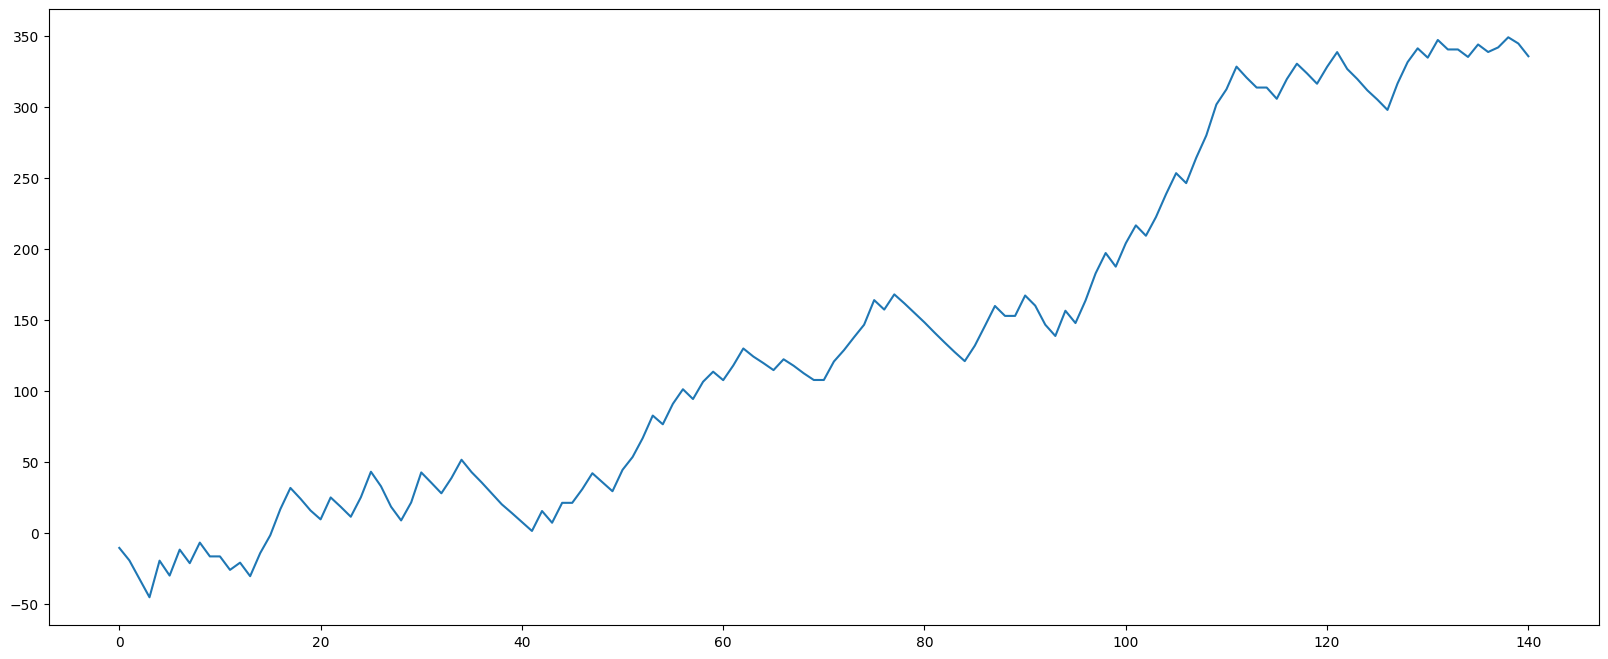

In [8]:
plt.figure(figsize=(20,8))
final_intraday_log['PnL'].cumsum().plot() 

In [9]:
#final_intraday_log.to_csv('trade_log_straddle.csv',index=False)

In [14]:
initial_capital = 1000000
final_intraday_log['Quantity'] = 100

In [15]:
final_intraday_log['Entry_Price'] = final_intraday_log['CE_Entry_Price'] + final_intraday_log['PE_Entry_Price']
final_intraday_log['Exit_Price'] = final_intraday_log['CE_Exit_Price'] + final_intraday_log['PE_Exit_Price']

In [16]:
final_intraday_log['Entry_Including_Slippage'] = final_intraday_log['Entry_Price'] - (final_intraday_log['Entry_Price'] * 0.02)#(intraday_trade_log['Entry_Price']*0.02) 
final_intraday_log['Exit_Including_Slippage'] = final_intraday_log['Exit_Price'] + (final_intraday_log['Exit_Price'] * 0.02)#(intraday_trade_log['Entry_Price']*0.02) 

In [17]:
final_intraday_log['Pnl_Including_slippages'] = (final_intraday_log['Entry_Including_Slippage'] - final_intraday_log['Exit_Including_Slippage']) * final_intraday_log['Quantity']

In [18]:
final_intraday_log['Pnl_including_Slippages_Cumulative'] = final_intraday_log['Pnl_Including_slippages'].cumsum()

In [21]:
final_intraday_log['Equity'] = 0
final_intraday_log['Rate_of_return'] = 0

In [22]:
for i in list(final_intraday_log.index):
    # if i == 0:
    #     intraday_trade_log['Equity'].iloc[i] = initial_capital + intraday_trade_log['Pnl_Including_slippages'].iloc[i]
    #     intraday_trade_log['Rate_of_return'].iloc[i] = (intraday_trade_log['Pnl_Including_slippages'].iloc[i] / initial_capital) * 100
    # else:
    #     intraday_trade_log['Equity'].iloc[i] = initial_capital['Equity'].iloc[i-1] + intraday_trade_log['Pnl_Including_slippages'].iloc[i]
    #     intraday_trade_log['Rate_of_return'].iloc[i] = (intraday_trade_log['Pnl_Including_slippages'].iloc[i]/intraday_trade_log['Equity'].iloc[i-1])*100
    if i == 0:
        final_intraday_log['Equity'].iloc[i] = initial_capital + final_intraday_log['Pnl_Including_slippages'].iloc[i]
        final_intraday_log['Rate_of_return'].iloc[i] = (final_intraday_log['Pnl_Including_slippages'].iloc[i]/initial_capital)*100
    else:
        final_intraday_log['Equity'].iloc[i] = final_intraday_log['Equity'].iloc[i-1] + final_intraday_log['Pnl_Including_slippages'].iloc[i]
        final_intraday_log['Rate_of_return'].iloc[i] = (final_intraday_log['Pnl_Including_slippages'].iloc[i]/final_intraday_log['Equity'].iloc[i-1])*100

C:\Users\admin\AppData\Local\Temp\ipykernel_7572\2934793840.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_log['Equity'].iloc[i] = initial_capital + final_intraday_log['Pnl_Including_slippages'].iloc[i]
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\2934793840.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_log['Rate_of_return'].iloc[i] = (final_intraday_log['Pnl_Including_slippages'].iloc[i]/initial_capital)*100
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\2934793840.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [12]:
win_rate = round(len(final_intraday_log[final_intraday_log['PnL']>0])/len(final_intraday_log),2)
print(f'Win Rate:{win_rate}')

mean_win = final_intraday_log[final_intraday_log['PnL']>0]['PnL'].mean()
mean_loss = final_intraday_log[final_intraday_log['PnL']<0]['PnL'].mean()
risk_reward = abs(mean_win/mean_loss)
expectancy = round((win_rate*risk_reward) - ((1-win_rate)*1),2)

print(f'Expectancy:{expectancy}')

Win Rate:0.46
Expectancy:0.27


In [23]:
number_of_trading_days_in_a_year = 252
risk_free_interest_rate = 5
mean = final_intraday_log['Rate_of_return'].mean() * number_of_trading_days_in_a_year - risk_free_interest_rate
sigma = final_intraday_log['Rate_of_return'].std() * np.sqrt(number_of_trading_days_in_a_year)
sharpe_ratio = round(mean/sigma,2)
print(f'Sharpe Ratio:{sharpe_ratio}')

Sharpe Ratio:-1.48


In [24]:
downside_standard_deviation = final_intraday_log[final_intraday_log['Rate_of_return']<0]['Rate_of_return'].std() * np.sqrt(number_of_trading_days_in_a_year)
sortino_ratio = round(mean/downside_standard_deviation,2)
print(f'Sortino Ratio:{sortino_ratio}')

Sortino Ratio:-5.02


In [25]:
final_intraday_log['Drawdown'] = final_intraday_log['Pnl_including_Slippages_Cumulative'] - final_intraday_log['Pnl_including_Slippages_Cumulative'].cummax()
max_drawdown = round(final_intraday_log['Drawdown'].min(),2)
print(f'Max Drawdown [Rs.] :{max_drawdown}')

max_drawdown_percent = round(max_drawdown/final_intraday_log[final_intraday_log['Drawdown'] == final_intraday_log['Drawdown'].min()]['Equity'].iloc[0]*100,2)
print(f'Max Drawdown Percent:{max_drawdown_percent}')

Max Drawdown [Rs.] :-6931.51
Max Drawdown Percent:-0.7


In [26]:
final_intraday_log['Recovery'] = 0
for i in range(len(final_intraday_log)):
    if (final_intraday_log['Drawdown'].iloc[i] < 0):
        final_intraday_log['Recovery'].iloc[i] = final_intraday_log['Recovery'].iloc[i-1] + 1
recovery_trades = final_intraday_log['Recovery'].max()

print(f'Number of trades done from Drawdown to achieve a new peak: {recovery_trades}')

Number of trades done from Drawdown to achieve a new peak: 37


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\18049188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_log['Recovery'].iloc[i] = final_intraday_log['Recovery'].iloc[i-1] + 1
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\18049188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_log['Recovery'].iloc[i] = final_intraday_log['Recovery'].iloc[i-1] + 1
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\18049188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [27]:
intraday_trade_log_equity_high = final_intraday_log[final_intraday_log['Recovery'] == 0]
intraday_trade_log_equity_high['number_days_between_equity_highs'] = (intraday_trade_log_equity_high['Entry_Datetime'] - intraday_trade_log_equity_high['Entry_Datetime'].shift())
recovery_days = int(intraday_trade_log_equity_high['number_days_between_equity_highs'].apply(lambda x: x.days).max())
print(f'Number of Days taken from Drawdown to achieve a new peak: {recovery_days}')

Number of Days taken from Drawdown to achieve a new peak: 58


C:\Users\admin\AppData\Local\Temp\ipykernel_7572\2508814227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log_equity_high['number_days_between_equity_highs'] = (intraday_trade_log_equity_high['Entry_Datetime'] - intraday_trade_log_equity_high['Entry_Datetime'].shift())


In [28]:
number_of_trading_days_for_this_backtest = (final_intraday_log.iloc[-1]['Entry_Datetime'].date() - final_intraday_log.iloc[0]['Entry_Datetime'].date()).days
cagr = (((final_intraday_log.iloc[-1]['Equity']/initial_capital)**(1/(number_of_trading_days_for_this_backtest/365)))-1)*100
cagr = round(cagr,2)

print(f'CAGR:{cagr}')

CAGR:2.33


In [29]:
calmar_ratio = round(abs(cagr/max_drawdown_percent),2)
print(f'Calmar Ratio:{calmar_ratio}')

Calmar Ratio:3.33


In [32]:
backtest_start_date = final_intraday_log.iloc[0]['Entry_Datetime'].date()
backtest_start_date

backtest_end_date = final_intraday_log.iloc[-1]['Entry_Datetime'].date()
backtest_end_date

number_of_trades = len(final_intraday_log)
number_of_trades
print(f"Back Test Start date = {backtest_start_date}, Back Test End date = {backtest_end_date} and total number of trades = {number_of_trades}")

Back Test Start date = 2022-05-02, Back Test End date = 2022-11-30 and total number of trades = 141


In [33]:
number_of_wins = len(final_intraday_log[final_intraday_log['Pnl_Including_slippages']>0])
print(f'Number of Wins: {number_of_wins}')

number_of_losses = len(final_intraday_log[final_intraday_log['Pnl_Including_slippages']<0])
print(f'Number of Losses: {number_of_losses}')

average_profit_per_trade = round(final_intraday_log[final_intraday_log['Pnl_Including_slippages'] > 0]['Pnl_Including_slippages'].mean(),2)
print(f'Average Profit Per Trade: {average_profit_per_trade}')

average_loss_per_trade = round(final_intraday_log[final_intraday_log['Pnl_Including_slippages'] < 0]['Pnl_Including_slippages'].mean(),2)
print(f'Average Loss Per Trade: {average_loss_per_trade}')

max_pnl = round(final_intraday_log['Pnl_Including_slippages'].max(),2)
print(f'Max PnL Point:{max_pnl}')

min_pnl = round(final_intraday_log['Pnl_Including_slippages'].min(),2)
print(f'Min PnL Point:{min_pnl}')

median_of_trade = round(final_intraday_log['Pnl_Including_slippages'].median(),2)
print(f'Median:{median_of_trade}')

Number of Wins: 65
Number of Losses: 76
Average Profit Per Trade: 1225.61
Average Loss Per Trade: -870.82
Max PnL Point:2396.36
Min PnL Point:-1755.58
Median:-195.2


In [34]:
gross_profit = final_intraday_log[final_intraday_log['Pnl_Including_slippages']>0]['Pnl_Including_slippages'].sum()
gross_loss = final_intraday_log[final_intraday_log['Pnl_Including_slippages']<0]['Pnl_Including_slippages'].sum()

profit_factor = round(abs(gross_profit/gross_loss),2)
print(f'Profit Factor:{profit_factor}')

outlier_adjusted_profit_factor = round(abs((gross_profit-max_pnl)/gross_loss),2)
print(f'Outlier Adjusted Profit Factor:{outlier_adjusted_profit_factor}')

Profit Factor:1.2
Outlier Adjusted Profit Factor:1.17


In [35]:
final_intraday_log['Continuous_Wins'] = 0
final_intraday_log['Continuous_Losses'] = 0

In [36]:
for i in range(1,len(final_intraday_log)):
    if final_intraday_log['Pnl_Including_slippages'].iloc[i-1] > 0:
        final_intraday_log['Continuous_Wins'].iloc[i] = final_intraday_log['Continuous_Wins'].iloc[i-1]+1
    if final_intraday_log['Pnl_Including_slippages'].iloc[i-1] < 0:
        final_intraday_log['Continuous_Losses'].iloc[i] = final_intraday_log['Continuous_Losses'].iloc[i-1]+1

C:\Users\admin\AppData\Local\Temp\ipykernel_7572\1932209109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_log['Continuous_Losses'].iloc[i] = final_intraday_log['Continuous_Losses'].iloc[i-1]+1
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\1932209109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_intraday_log['Continuous_Losses'].iloc[i] = final_intraday_log['Continuous_Losses'].iloc[i-1]+1
C:\Users\admin\AppData\Local\Temp\ipykernel_7572\1932209109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [37]:
consecutive_wins = final_intraday_log['Continuous_Wins'].max()
consecutive_losses = final_intraday_log['Continuous_Losses'].max()
print(f'Consecutive Wins:{consecutive_wins}')
print(f'Consecutive Losses:{consecutive_losses}')

Consecutive Wins:5
Consecutive Losses:7


In [38]:
metrics = pd.DataFrame(columns=['Backtest Start Date','Backtest End Date','Number of Trades','Number of Wins','Number of Losses','Average Profit','Average Loss','Maximum Profit Points','Maximum Loss Points','Median Trade','Win Rate','Expectancy','Sharpe Ratio','Sortino Ratio','Max Drawdown','Max Drawdown Percent','Days Taken to Recover From Drawdown','Number of Trades to Recover From Drawdown','Calmar','CAGR','Consecutive Wins','Consecutive Losses','Profit Factor (Amount of Profit per unit of Loss)','Outlier Adjusted Profit Factor (Profit Factor except that One Exceptional Biggest Winner)'])

In [39]:
new_row = pd.DataFrame({'Backtest Start Date':[backtest_start_date], 
                          'Backtest End Date':[backtest_end_date], 
                          'Number of Trades':[number_of_trades],
                          'Number of Wins':[number_of_wins],
                          'Number of Losses':[number_of_losses],
                          'Average Profit':[average_profit_per_trade],
                          'Average Loss':[average_loss_per_trade],
                          'Maximum Profit Points':[max_pnl],
                          'Maximum Loss Points':[min_pnl],
                          'Median Trade':[median_of_trade],
                          'Win Rate':[win_rate],
                          'Expectancy':[expectancy],
                          'Sharpe Ratio':[sharpe_ratio],
                          'Sortino Ratio':[sortino_ratio],
                          'Max Drawdown':[max_drawdown],
                          'Max Drawdown Percent':[max_drawdown_percent],
                          'Days Taken to Recover From Drawdown':[recovery_days],
                          'Number of Trades to Recover From Drawdown':[recovery_trades],
                          'Calmar':[calmar_ratio],
                          'CAGR':[cagr],
                          'Consecutive Wins':[consecutive_wins],
                          'Consecutive Losses':[consecutive_losses],
                          'Profit Factor (Amount of Profit per unit of Loss)':[profit_factor],
                          'Outlier Adjusted Profit Factor (Profit Factor except that One Exceptional Biggest Winner)':[outlier_adjusted_profit_factor]})

metrics = pd.concat([metrics,new_row], ignore_index=True)
metrics

,Backtest Start Date,Backtest End Date,Number of Trades,Number of Wins,Number of Losses,Average Profit,Average Loss,Maximum Profit Points,Maximum Loss Points,Median Trade,Win Rate,Expectancy,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Drawdown Percent,Days Taken to Recover From Drawdown,Number of Trades to Recover From Drawdown,Calmar,CAGR,Consecutive Wins,Consecutive Losses,Profit Factor (Amount of Profit per unit of Loss),Outlier Adjusted Profit Factor (Profit Factor except that One Exceptional Biggest Winner)
0,2022-05-02,2022-11-30,141,65,76,1225.61,-870.82,2396.36,-1755.58,-195.2,0.46,0.27,-1.48,-5.02,-6931.51,-0.7,58,37,3.33,2.33,5,7,1.2,1.17
